In [1]:
import os
import json
from pprint import pprint
from datetime import datetime
from collections import defaultdict

import chardet
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/schilver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/schilver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloa

True

## Characterize News

In [2]:
NEWS_PATH = 'MC1/News Articles/'

def get_provider_id(provider_name):
    return provider_name.lower().replace(' ', '-')

news_providers = {get_provider_id(p): {'name': p} for p in os.listdir(NEWS_PATH) if os.path.isdir(os.path.join(NEWS_PATH, p))}

for p, v in news_providers.items():
    articles = [a for a in os.listdir(os.path.join(NEWS_PATH, v['name'])) if a.endswith('.txt')]
    v['nArticles'] = len(articles)
    v['articles'] = articles

print('News Providers')
pprint(news_providers)

News Providers
{'all-news-today': {'articles': ['698.txt',
                                 '714.txt',
                                 '77.txt',
                                 '612.txt',
                                 '603.txt',
                                 '617.txt',
                                 '341.txt',
                                 '237.txt',
                                 '753.txt',
                                 '154.txt',
                                 '554.txt',
                                 '391.txt',
                                 '420.txt',
                                 '152.txt',
                                 '135.txt',
                                 '121.txt',
                                 '251.txt',
                                 '683.txt'],
                    'nArticles': 18,
                    'name': 'All News Today'},
 'athena-speaks': {'articles': ['466.txt',
                                '270.txt',
                       

In [3]:
articles = []

date_parser_formats = ['%Y/%m/%d', '%d %B %Y']

def get_encoding(filepath):
    with open(filepath, 'rb') as f:
        return chardet.detect(f.read())['encoding']
    
def parse_date(date_str):
    for fmt in date_parser_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            pass
    return None

def process_text(text):
    # Get the list of stopwords
    stop_words = set(stopwords.words('english'))
    # Tokenize the text
    word_tokens = word_tokenize(text)
    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Filter out the stopwords and lemmatize the remaining words
    def lemmatize_word(word):
        lemmatized = lemmatizer.lemmatize(word)
        if word.isupper():
            lemmatized = lemmatized.upper()
        elif word[0].isupper():
            lemmatized = lemmatized.capitalize()
        return lemmatized
    processed_text = [
        lemmatize_word(word) for word in word_tokens if word.lower() not in stop_words
    ]
    # Join the processed words and return the result
    return ' '.join(processed_text)
    
def parse_article(filepath):
    encoding = get_encoding(filepath)
    article_lines = []
    location = None
    title = ''
    next_is_date = False
    with open(filepath, 'r', encoding=encoding) as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith('SOURCE'):
                source = " ".join(line.split(':')[1:]).strip()
            elif line.startswith('TITLE'):
                title = " ".join(line.split(':')[1:]).strip()
            elif line.startswith('PUBLISHED: By'):
                next_is_date = True
                continue
            elif line.startswith('PUBLISHED') or next_is_date:
                if next_is_date:
                    date_str = line.strip()
                else:
                    date_str = line.split(':')[1].strip()
                published = parse_date(date_str)
                next_is_date = False
            elif line.startswith('LOCATION'):
                location = line.split(':')[1].strip()
            elif len(line) > 0:
                article_lines.append(line)
    # Remove stopwords
    article = ' '.join(article_lines)
    parsed_article = process_text(article)
    parsed_title = process_text(title)
    return {
        'source': source,
        'pure_title': title,
        'title': parsed_title,
        'published': published,
        'location': location,
        'pure_text': article,
        'article': parsed_article,
        'filepath': filepath
    }

for p, v in news_providers.items():
    for a in v['articles']:
        filepath = os.path.join(NEWS_PATH, v['name'], a)
        encoding = get_encoding(filepath)
        with open(filepath, 'r', encoding=encoding) as f:
            try:
                article = parse_article(filepath)
            except Exception as e:
                raise Exception(f'Error parsing article {filepath}: {e}')
            article['provider'] = p
            articles.append(article)

In [4]:
df = pd.DataFrame(articles)
df.head()

,source,pure_title,title,published,location,pure_text,article,filepath,provider
0,The Wrap,POK REMIND LEADER MARTYRED,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,Leaders moving ceramic Wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,END PROTESTS POK ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,Fifteen member guard Kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,DEMONSTRATION ATTRACTS THOUSANDS SPITE RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,CELEBRATION DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gAStech-Kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,SHEET PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact Hyper Acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap


In [5]:
def compound_sentiments(sentiments):
    sentiment_scores = defaultdict(lambda : 0.0)
    for sentiment in sentiments:
        label = sentiment['label']
        score = sentiment['score']
        sentiment_scores[label] += score
    sentiment_scores = [(-v, l) for l, v in sentiment_scores.items()]
    sentiment_scores.sort()
    return sentiment_scores[0][1]

def get_sentiment(text, chunk_size=400):
    if chunk_size < 100:
        print(f'Error getting sentiment for text: {text}. Chunk size cannot be decreased to less than 100.')
        return None
    words = text.split(' ')
    chunks = []
    while len(words) >= chunk_size:
        chunk = words[:chunk_size]
        chunks.append(' '.join(chunk))
        words = words[chunk_size:]
    chunks.append(' '.join(words))
    try:
        sentiments = sentiment_pipeline(chunks)
    except Exception as e:
        print(f'Warn: Getting sentiment for text: {text}. Decreasing chunk size to {chunk_size-100} and trying again.')
        return get_sentiment(text, chunk_size=chunk_size-100)
    sentiment = compound_sentiments(sentiments)
    return sentiment

text = "Amazing!"
get_sentiment(text)

'positive'

In [6]:
df['sentiment'] = df.article.apply(lambda x: get_sentiment(x))
df['title_sentiment'] = df.title.apply(lambda x: get_sentiment(x))
df.head()

Warn: Getting sentiment for text: AWELON , CYNTHE/DOB : 3/20/1981/Time arrest : 0003 accused u/van : UNIT DRUG BLUMIAU , WILLEM/DOB : 2/15/1995/Time arrest : 2215 accused u/van : POSSESSION CHECKED SUBSTANCE ( HASHISH ) ; FOREIGN GUARANTEE BODROGI , Karmijn/12/1/1993/time arrest : 0230 accused u/van : POSSESSION CHECKED SUBSTANCE ( MDMC ) ; INTENTION PROVIDE CHECKED SUBSTANCE ( MDMC ) COARDA , SEVE/DOB : 5/13/1979/Time arrest : 1248 accused u/van : PEDESTRN SUCCEEDING USE CROSSWALK ; PEDESTRN SUBMITTED INDICATOR CUSEMA , BRITA/DOB : 1/7/1992/Time arrest : 2205 accused u/van : SHOP ROBBER STABLE PLEGEN-VIJFDE DEGREE ROBBER STABLE DUNNA , THAD/DOB : 9/20/1974/Time arrest : 1500 accused u/van : ROBBER STABLE ALREADY ANDER-DERDE DEGREE GUDENZ , KEL/DOB : 7/2/1995/Time arrest : 1630 accused u/van : LEAVING BEHIND MAINTAIN CONTROL ; DWLU HOLANDE , ANDA/DOB : 3/26/1981/Time arrest : 0003 accused u/van : INAPPROPRIATE SLIGHTLY BRAKE KIBALIAU , IYAN/DOB : 4/3/1994/Time arrest : 1500 accused u/v

,source,pure_title,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment
0,The Wrap,POK REMIND LEADER MARTYRED,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,Leaders moving ceramic Wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,END PROTESTS POK ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,Fifteen member guard Kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,DEMONSTRATION ATTRACTS THOUSANDS SPITE RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,CELEBRATION DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gAStech-Kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,SHEET PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact Hyper Acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral


In [7]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df.title + ' ' + df.article).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=vectorizer.get_feature_names_out())

# Delete Number Columns
for c in tfidf_df.columns:
    if c[0].isnumeric():
        del tfidf_df[c]

tfidf_df.head()

,aandacht,abandonment,abducted,abduction,abila,abilia,abilians,ability,ablaze,able,...,youth,zeal,zeeschaliegas,zero,zoeken,zoekende,zone,zoon,zowat,éramos
0,0.0,0.0,0.0,0.0,0.024263,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.047824,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


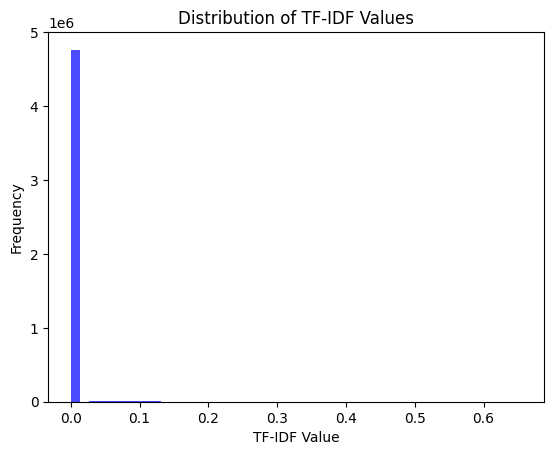

In [8]:
# Assuming `tfidf_df` is your DataFrame with TF-IDF values
tfidf_values = tfidf_df.values.flatten()

# Plotting the distribution of TF-IDF values
plt.hist(tfidf_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of TF-IDF Values')
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.show()

# Calculating descriptive statistics
mean_tfidf = tfidf_values.mean()
std_tfidf = tfidf_values.std()

# Setting a threshold value
tfidf_threshold = mean_tfidf + std_tfidf 

# Experimental Threshold
tfidf_threshold = 0.02

In [9]:
# Calculate cosine similarity
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Convert the cosine similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=tfidf_df.index, columns=tfidf_df.index)

# Display the cosine similarity DataFrame
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,835,836,837,838,839,840,841,842,843,844
0,1.000000,0.058388,0.124268,0.056098,0.029269,0.110692,0.033881,0.030148,0.273686,0.156998,...,0.136483,0.046265,0.029824,0.103676,0.023619,0.020397,0.043935,0.018888,0.037499,0.033686
1,0.058388,1.000000,0.014520,0.019573,0.005969,0.065741,0.035127,0.000000,0.090593,0.071553,...,0.069492,0.084906,0.069741,0.039824,0.028599,0.019704,0.050738,0.017975,0.013797,0.027841
2,0.124268,0.014520,1.000000,0.121941,0.020922,0.046908,0.040970,0.017639,0.077396,0.142990,...,0.058848,0.017124,0.041849,0.061314,0.023670,0.051372,0.035426,0.010240,0.029623,0.032770
3,0.056098,0.019573,0.121941,1.000000,0.028148,0.059340,0.028315,0.028168,0.071517,0.081720,...,0.044092,0.016290,0.036026,0.059815,0.080424,0.031192,0.049771,0.109018,0.025829,0.036967
4,0.029269,0.005969,0.020922,0.028148,1.000000,0.065630,0.049753,0.722454,0.061627,0.093693,...,0.046707,0.001547,0.034320,0.014233,0.011118,0.049736,0.019877,0.011516,0.010385,0.101963


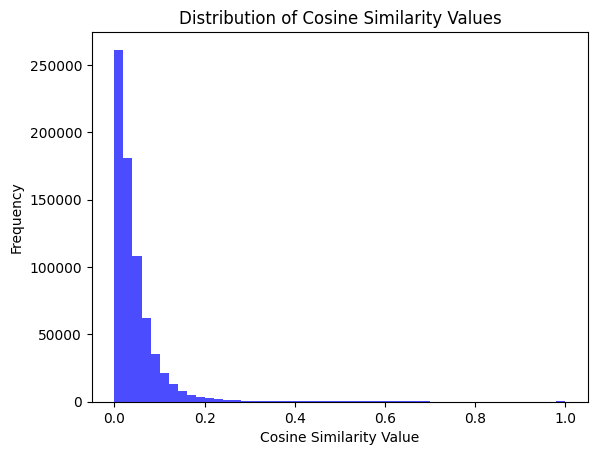

0.11537869709475335


In [10]:
# Assuming `tfidf_df` is your DataFrame with TF-IDF values
cosine_sim_values = cosine_sim_df.values.flatten()

# Plotting the distribution of TF-IDF values
plt.hist(cosine_sim_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cosine Similarity Values')
plt.xlabel('Cosine Similarity Value')
plt.ylabel('Frequency')
plt.show()

# Calculating descriptive statistics
mean_cosin = cosine_sim_values.mean()
std_cosin = cosine_sim_values.std()

# Setting a threshold value
cosin_threshold = mean_cosin + std_cosin 
print(cosin_threshold)

# Experimental Threshold
cosin_threshold = 0.3

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

distance_matrix = 1 - cosine_sim_matrix
linkage_matrix = linkage(distance_matrix, method='average')

clusters = fcluster(linkage_matrix, t=1.5, criterion='distance')

df['cluster'] = clusters

clusters_dict = defaultdict(list)

for i, cluster in enumerate(clusters):
    clusters_dict[cluster].append(i)

clusters = list(clusters_dict.values())

for cluster in clusters:
    cluster.sort(
        key=lambda x: (df.iloc[x].published, x), reverse=True
    )

with open('data/article_clusters.json', 'w') as f:
    json.dump(clusters, f)

In [14]:
# Get the indices of similar articles
cosine_sim_indices = list(cosine_sim_df[cosine_sim_df > cosin_threshold].stack().index)
similar_articles = defaultdict(list)
for i, j in cosine_sim_indices:
    if i == j:
        continue
    similar_articles[i].append(j)
pprint(similar_articles)

defaultdict(<class 'list'>,
            {0: [32, 159, 267, 496, 717],
             1: [36, 164, 234, 511, 800],
             2: [28, 154],
             3: [33, 162, 206, 497, 762],
             4: [7, 21, 22, 26, 48, 155, 166, 254, 256, 512, 712],
             5: [13, 14, 47, 153, 174, 238, 505, 752],
             6: [35, 163, 265, 509],
             7: [4,
                 21,
                 22,
                 26,
                 39,
                 48,
                 155,
                 158,
                 166,
                 254,
                 256,
                 268,
                 512,
                 698,
                 707,
                 712,
                 742],
             8: [11,
                 12,
                 23,
                 30,
                 41,
                 49,
                 160,
                 173,
                 219,
                 220,
                 244,
                 246,
                 249,
            

In [15]:
def get_dict(x, threshold):
    scores = [(k, v) for k, v in x.items() if v > threshold]
    scores.sort(key=lambda x: x[1], reverse=True)
    scores = json.dumps(dict(scores))
    return scores

In [16]:
df['tfidf'] = tfidf_df.apply(lambda x: get_dict(x, tfidf_threshold), axis=1)
df['cosine_sim'] = cosine_sim_df.apply(lambda x: get_dict(x, cosin_threshold), axis=1)
df.head()

,source,pure_title,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment,cluster,tfidf,cosine_sim
0,The Wrap,POK REMIND LEADER MARTYRED,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,Leaders moving ceramic Wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral,20,"{""elian"": 0.3664370054952434, ""remind"": 0.2257...","{""0"": 1.0000000000000004, ""32"": 0.597789035630..."
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,END PROTESTS POK ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,Fifteen member guard Kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative,89,"{""song"": 0.2629169492132326, ""port"": 0.2270452...","{""1"": 1.0000000000000002, ""36"": 0.517591999325..."
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,DEMONSTRATION ATTRACTS THOUSANDS SPITE RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral,75,"{""rain"": 0.24114892485271905, ""person"": 0.2265...","{""2"": 0.9999999999999998, ""154"": 0.47398379604..."
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,CELEBRATION DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gAStech-Kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral,38,"{""kleptocracy"": 0.3345181467682554, ""delivered...","{""3"": 1.0, ""206"": 0.6203471216791053, ""162"": 0..."
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,SHEET PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact Hyper Acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral,182,"{""health"": 0.2138346861959771, ""elodis"": 0.189...","{""4"": 1.0, ""7"": 0.7224538237994964, ""256"": 0.6..."


In [17]:
future_articles = {}
def extract_future(parent, children):
    parent_date = df.iloc[parent].published
    extracted_children = []
    for child in children:
        child_date = df.iloc[child].published
        if child_date >= parent_date:
            extracted_children.append((child, child_date))
    extracted_children.sort(key=lambda x: x[1])
    future_articles[parent] = extracted_children

for i, value in similar_articles.items():
    extract_future(i, value)

future_articles

{0: [(32, Timestamp('2012-06-22 00:00:00')),
  (159, Timestamp('2012-06-22 00:00:00'))],
 1: [(36, Timestamp('2005-04-06 00:00:00')),
  (511, Timestamp('2005-04-06 00:00:00')),
  (800, Timestamp('2005-04-06 00:00:00')),
  (164, Timestamp('2005-04-07 00:00:00'))],
 2: [(28, Timestamp('2012-11-12 00:00:00'))],
 3: [(33, Timestamp('2014-01-19 00:00:00')),
  (162, Timestamp('2014-01-19 00:00:00')),
  (206, Timestamp('2014-01-19 00:00:00')),
  (497, Timestamp('2014-01-19 00:00:00')),
  (762, Timestamp('2014-01-19 00:00:00'))],
 4: [(254, Timestamp('2002-05-25 00:00:00')),
  (48, Timestamp('2002-05-26 00:00:00')),
  (7, Timestamp('2002-05-27 00:00:00')),
  (155, Timestamp('2002-05-27 00:00:00')),
  (512, Timestamp('2004-05-29 00:00:00')),
  (21, Timestamp('2004-05-30 00:00:00'))],
 5: [(153, Timestamp('1998-03-21 00:00:00')),
  (14, Timestamp('1998-04-26 00:00:00')),
  (174, Timestamp('1998-04-27 00:00:00')),
  (13, Timestamp('1998-05-17 00:00:00'))],
 6: [(163, Timestamp('1993-02-04 00:00:0

In [32]:
chains = {}
def extract_chain(parent, children, chain = []):
    if parent in chain:
        return []
    if parent in chains:
        return chains[parent]
    chain.append(parent)
    child = None
    for child, _ in children:
        if child in chain:
            continue
        break
    if child is not None:
        chain += extract_chain(child, future_articles[child], chain)
    return list(set(chain))

for i, value in future_articles.items():
    chains[i] = extract_chain(i, value, [])

print('Chains')
print(chains)

Chains
{0: [0, 32, 159], 1: [1, 36, 837, 199, 363, 141, 336, 597, 533, 789, 409, 763, 573, 511], 2: [2, 28], 3: [3, 515, 534, 543, 544, 33, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 574, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 79, 82, 83, 85, 84, 86, 601, 93, 127, 129, 132, 145, 667, 162, 688, 191, 195, 206, 207, 208, 212, 213, 215, 216, 218, 221, 222, 224, 226, 228, 229, 230, 231, 232, 233, 747, 235, 240, 241, 242, 245, 247, 250, 255, 257, 258, 259, 260, 261, 263, 270, 273, 274, 275, 276, 283, 287, 291, 294, 296, 298, 300, 303, 304, 305, 306, 307, 309, 312, 825, 314, 315, 316, 317, 318, 320, 321, 322, 324, 326, 327, 330, 332, 354, 359, 362, 382, 392, 406, 413, 428, 443, 494, 497], 4: [512, 707, 4, 742, 7, 39, 158, 268, 48, 21, 155, 254], 5: [740, 5, 759, 43, 45, 14, 174, 13, 211, 503, 153, 156, 253], 6: [163, 6], 7: [512, 742, 7, 39, 268, 21, 155, 158], 8: [0, 32, 8, 267, 717, 496, 30, 159], 9: [0, 8, 9, 11, 12, 267, 142, 402, 786, 23, 797, 30, 159, 1

In [17]:
df['chain'] = df.index.map(chains)

In [116]:
df.to_pickle('data/news_articles.pkl')
df.to_csv('data/news_articles.csv', index=False)
df.to_excel('data/news_articles.xlsx', index=False)

In [73]:
df = pd.read_pickle('data/news_articles.pkl')
df.head()

,source,pure_title,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment,cluster,tfidf,cosine_sim
0,The Wrap,POK REMIND LEADER MARTYRED,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,Leaders moving ceramic Wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral,20,"{""elian"": 0.3664370054952434, ""remind"": 0.2257...","{""0"": 1.0000000000000004, ""32"": 0.597789035630..."
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,END PROTESTS POK ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,Fifteen member guard Kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative,89,"{""song"": 0.2629169492132326, ""port"": 0.2270452...","{""1"": 1.0000000000000002, ""36"": 0.517591999325..."
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,DEMONSTRATION ATTRACTS THOUSANDS SPITE RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral,75,"{""rain"": 0.24114892485271905, ""person"": 0.2265...","{""2"": 0.9999999999999998, ""154"": 0.47398379604..."
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,CELEBRATION DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gAStech-Kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral,38,"{""kleptocracy"": 0.3345181467682554, ""delivered...","{""3"": 1.0, ""206"": 0.6203471216791053, ""162"": 0..."
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,SHEET PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact Hyper Acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral,182,"{""health"": 0.2138346861959771, ""elodis"": 0.189...","{""4"": 1.0, ""7"": 0.7224538237994964, ""256"": 0.6..."


In [74]:
# Extract proper nouns from the text
noun_threshold = 0.02
pns = []
cns = []
def extract_nouns(row):
    word_tokens = word_tokenize(row.article)
    tfidf = json.loads(row.tfidf)
    # Get the part of speech tags of the words
    pos_tags = nltk.pos_tag(word_tokens)

    def check_importance(word):
        try:
            importance = tfidf[word.lower()]
        except KeyError:
            return False
        return importance
    
    # Extract the proper nouns
    def extract_nouns_from_tags(tags, proper=True):
        nouns = []
        continuous = []
        if proper:
            check_tags = ['NNP', 'NNPS']
        else:
            check_tags = ['NN', 'NNS']
        importance = 0
        for word, pos in tags:
            importance = max(check_importance(word), importance)
            if pos in check_tags and importance > noun_threshold:
                continuous.append(word)
            elif len(continuous) > 0:
                nouns.append((' '.join(continuous), importance))
                continuous = []
        if len(continuous) > 0:
            nouns.append((' '.join(continuous), importance))
        return nouns
    proper_nouns = extract_nouns_from_tags(pos_tags, proper=True)
    common_nouns = extract_nouns_from_tags(pos_tags, proper=False)

    proper_nouns = list(set(proper_nouns))
    common_nouns = list(set(common_nouns))

    # Return the proper nouns
    pns.append(proper_nouns)
    cns.append(common_nouns)

df.apply(extract_nouns, axis=1)
df['proper_nouns'] = pns
df['common_nouns'] = cns
df.head()

,source,pure_title,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment,cluster,tfidf,cosine_sim,proper_nouns,common_nouns
0,The Wrap,POK REMIND LEADER MARTYRED,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,Leaders moving ceramic Wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral,20,"{""elian"": 0.3664370054952434, ""remind"": 0.2257...","{""0"": 1.0000000000000004, ""32"": 0.597789035630...","[(Abila, 0.3664370054952434), (Juliana, 0.3664...","[(mob, 0.3664370054952434), (minute, 0.3664370..."
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,END PROTESTS POK ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,Fifteen member guard Kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative,89,"{""song"": 0.2629169492132326, ""port"": 0.2270452...","{""1"": 1.0000000000000002, ""36"": 0.517591999325...","[(POK, 0.15949667675028065), (Tiskele, 0.22704...","[(weapon, 0.22704525720303453), (farmer, 0.262..."
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,DEMONSTRATION ATTRACTS THOUSANDS SPITE RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral,75,"{""rain"": 0.24114892485271905, ""person"": 0.2265...","{""2"": 0.9999999999999998, ""154"": 0.47398379604...","[(Kronos, 0.24114892485271905), (Wednesday, 0....","[(say, 0.24114892485271905), (region worker, 0..."
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,CELEBRATION DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gAStech-Kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral,38,"{""kleptocracy"": 0.3345181467682554, ""delivered...","{""3"": 1.0, ""206"": 0.6203471216791053, ""162"": 0...","[(Kapelou II CEO Sten Sanjorge Jr., 0.33451814...","[(celebrate, 0.3123272626821827), (kleptocracy..."
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,SHEET PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact Hyper Acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral,182,"{""health"": 0.2138346861959771, ""elodis"": 0.189...","{""4"": 1.0, ""7"": 0.7224538237994964, ""256"": 0.6...","[(Nespola, 0.2138346861959771), (Internet, 0.2...","[(boring technique giant toll, 0.1391917958785..."


In [27]:
data = []
def check_word(word):
    return (word.isalpha() or word.isnumeric()) and len(word) > 1

for cluster in clusters:
    proper_nouns = defaultdict(lambda : 0)
    common_nouns = defaultdict(lambda : 0)
    for i in cluster:
        pns = dict(df.iloc[i].proper_nouns)
        cns = dict(df.iloc[i].common_nouns)
        for pn, importance in pns.items():
            try:
                proper_nouns[pn] += importance
            except KeyError:
                proper_nouns[pn] = importance
        for cn, importance in cns.items():
            try:
                common_nouns[cn] += importance
            except KeyError:
                common_nouns[cn] = importance
    proper_nouns = [(k, v) for k, v in proper_nouns.items() if check_word(k)]
    proper_nouns.sort(key=lambda x: (-x[1], x[0]))
    common_nouns = [(k, v) for k, v in common_nouns.items() if check_word(k)]
    common_nouns.sort(key=lambda x: (-x[1], x[0]))
    data.append({
        'cluster': cluster,
        'proper_nouns': proper_nouns,
        'common_nouns': common_nouns
    })
with open('data/cluster_nouns.json', 'w') as f:
    json.dump(data, f)

In [108]:
def get_total_sentiment(row):
    sentiment = row.sentiment
    title_sentiment = row.title_sentiment
    if sentiment == 'neutral':
        return title_sentiment
    elif title_sentiment == 'neutral':
        return sentiment
    elif title_sentiment == 'negative' or sentiment == 'negative':
        return 'negative'
    else:
        return 'positive'

df['total_sentiment'] = df.apply(get_total_sentiment, axis=1)

In [5]:
agg_df = df.groupby('provider').total_sentiment.value_counts()

In [7]:
agg_df = agg_df.unstack().fillna(0)

In [9]:
agg_df.to_csv('data/provider_sentiment.csv')

In [11]:
chains = df.chain.to_dict()

In [15]:
count = 0
for i, chain in chains.items():
    count += len(chain)
count

38920

In [75]:
def check_word(word):
    return (word.isalpha() or word.isnumeric() or word.isupper()) and len(word) > 1

def get_tags(row):
    row_tags = [d[0].lower() for d in row.proper_nouns if check_word(d[0])]
    return row_tags
    
df['tags'] = df.apply(get_tags, axis=1)
df.head()

,source,pure_title,title,published,location,pure_text,article,filepath,provider,sentiment,title_sentiment,cluster,tfidf,cosine_sim,proper_nouns,common_nouns,tags
0,The Wrap,POK REMIND LEADER MARTYRED,POK REMIND LEADER MARTYRED,2012-06-21,"ABILA, Kronos",In LEADERs of moving ceramics Wednesday of act...,Leaders moving ceramic Wednesday activist grou...,MC1/News Articles/The Wrap/116.txt,the-wrap,neutral,neutral,20,"{""elian"": 0.3664370054952434, ""remind"": 0.2257...","{""0"": 1.0000000000000004, ""32"": 0.597789035630...","[(Abila, 0.3664370054952434), (Juliana, 0.3664...","[(mob, 0.3664370054952434), (minute, 0.3664370...","[abila, juliana, leader, kronos, elodis, karel..."
1,The Wrap,THE END OF PROTESTS POK IN ARRESTS,END PROTESTS POK ARRESTS,2005-04-06,"ELODIS, Kronos",Fifteen members of the guards of Kronos the ac...,Fifteen member guard Kronos activist organizat...,MC1/News Articles/The Wrap/17.txt,the-wrap,neutral,negative,89,"{""song"": 0.2629169492132326, ""port"": 0.2270452...","{""1"": 1.0000000000000002, ""36"": 0.517591999325...","[(POK, 0.15949667675028065), (Tiskele, 0.22704...","[(weapon, 0.22704525720303453), (farmer, 0.262...","[pok, tiskele, swinging, pok, kronos, gastech,..."
2,The Wrap,DEMONSTRATION ATTRACTS THOUSANDS IN SPITE OF RAIN,DEMONSTRATION ATTRACTS THOUSANDS SPITE RAIN,2012-11-12,"ABILA, Kronos",A heavy rain loved no thousands of citizens in...,heavy rain loved thousand citizen insuring vot...,MC1/News Articles/The Wrap/843.txt,the-wrap,neutral,neutral,75,"{""rain"": 0.24114892485271905, ""person"": 0.2265...","{""2"": 0.9999999999999998, ""154"": 0.47398379604...","[(Kronos, 0.24114892485271905), (Wednesday, 0....","[(say, 0.24114892485271905), (region worker, 0...","[kronos, wednesday]"
3,The Wrap,A CELEBRATION OF DELIVERED KLEPTOCRACY,CELEBRATION DELIVERED KLEPTOCRACY,2014-01-19,"ABILA, Kronos",After annual gAStech-Kronos the collective sta...,annual gAStech-Kronos collective staff employe...,MC1/News Articles/The Wrap/704.txt,the-wrap,positive,neutral,38,"{""kleptocracy"": 0.3345181467682554, ""delivered...","{""3"": 1.0, ""206"": 0.6203471216791053, ""162"": 0...","[(Kapelou II CEO Sten Sanjorge Jr., 0.33451814...","[(celebrate, 0.3123272626821827), (kleptocracy...","[kronos, gastech, kronos]"
4,The Wrap,THE SHEET OF THE PUBLIC HEALTH ELODIS - UPDATE,SHEET PUBLIC HEALTH ELODIS - UPDATE,2000-06-02,"ELODIS, Kronos",The environment impact of the Hyper Acidic has...,environment impact Hyper Acidic disposal subst...,MC1/News Articles/The Wrap/271.txt,the-wrap,neutral,neutral,182,"{""health"": 0.2138346861959771, ""elodis"": 0.189...","{""4"": 1.0, ""7"": 0.7224538237994964, ""256"": 0.6...","[(Nespola, 0.2138346861959771), (Internet, 0.2...","[(boring technique giant toll, 0.1391917958785...","[nespola, internet, abila, hasr, elodis, welln..."


In [76]:
people_data = pd.read_excel('data/people.xlsx', sheet_name='Sheet3')
people_data.head()

,name,role,impOfPeople,organization
0,Ada Campo-Corrente,Chief Information Officer for GASTech,10,GASTechBoard
1,"Sten Sanjorge, Jr",President & CEO GASTech,10,GASTechBoard
2,Ingrid Barranco,Chief Financial Officer of GASTech,9,GASTechBoard
3,Orhan Strum,Chief Operating Officer for GASTech,8,GASTechBoard
4,Linnea Bergen,Group Manager – Information Technology GASTech...,7,GASTechCommittee


In [77]:
email_data = pd.read_excel('data/updated_email.xlsx')
email_data.head()

,EmailIndex,From,To,Date,Subject,Email Type
0,0,Varja.Lagos@gastech.com.kronos,Varja.Lagos@gastech.com.kronos,01-06-2014 10:28,Patrol schedule changes,Official
1,0,Varja.Lagos@gastech.com.kronos,Hennie.Osvaldo@gastech.com.kronos,01-06-2014 10:28,Patrol schedule changes,Official
2,0,Varja.Lagos@gastech.com.kronos,Loreto.Bodrogi@gastech.com.kronos,01-06-2014 10:28,Patrol schedule changes,Official
3,0,Varja.Lagos@gastech.com.kronos,Inga.Ferro@gastech.com.kronos,01-06-2014 10:28,Patrol schedule changes,Official
4,1,Brand.Tempestad@gastech.com.kronos,Birgitta.Frente@gastech.com.kronos,01-06-2014 10:35,Wellhead flow rate data,Official


In [96]:
def extract_name(email):
    name, _ = email.split('@')
    name = " ".join(name.split('.'))
    return name

email_data['from_name'] = email_data.From.apply(extract_name)
email_data['to_name'] = email_data.To.apply(extract_name)
email_names = list(set(email_data.from_name.to_list() + email_data.to_name.to_list()))
all_names = list(set(email_names + people_data.name.to_list()))
all_names += ['gastech', 'pok', 'apa', 'government']

In [97]:
import numpy as np

email_names = {name: index for index, name in enumerate(email_names)}
email_links = []
for _, row in email_data.iterrows():
    email_links.append((email_names[row.from_name], email_names[row.to_name]))

adj_matrix = np.zeros((len(email_names), len(email_names)))
for i, j in email_links:
    adj_matrix[i][j] += 1
    adj_matrix[j][i] += 1
email_adj_df = pd.DataFrame(adj_matrix, columns=email_names.keys(), index=email_names.keys())
email_adj_df.to_csv('data/communication_frequency.csv')


In [98]:
articles_adj_matrix = np.zeros((len(all_names), len(all_names)))
all_names = [n.lower() for n in all_names]

def check_names(i, j, tags):
    if i == j:
        return False
    name1 = all_names[i].lower().split(' ')
    name2 = all_names[j].lower().split(' ')
    name1Present = False
    name2Present = False
    for tag in tags:
        if tag in name1:
            name1Present = True
        if tag in name2:
            name2Present = True
        if name1Present and name2Present:
            articles_adj_matrix[i][j] += 1
            articles_adj_matrix[j][i] += 1
            return True
    return False


for i in range(len(all_names)):
    for j in range(i+1, len(all_names)):
        df.tags.apply(lambda x: check_names(i, j, x))

pa_adj_df = pd.DataFrame(articles_adj_matrix, columns=all_names, index=all_names)
pa_adj_df.to_csv('data/people_article_frequency.csv')


In [111]:
gastech_articles = df[df.article.apply(lambda x: 'gastech' in x.lower())]
apa_articles = df[df.article.apply(lambda x: 'apa' in x.lower())]
pok_articles = df[df.article.apply(lambda x: 'pok' in x.lower())]
government_articles = df[df.article.apply(lambda x: 'government' in x.lower())]

In [105]:
gastech_articles.to_csv('data/gastech_articles.csv')
apa_articles.to_csv('data/apa_articles.csv')
pok_articles.to_csv('data/pok_articles.csv')
government_articles.to_csv('data/government_articles.csv')

In [115]:
def extract_timeline_sentiment(articles):
    timeline_data = {}
    articles = articles.sort_values(by='published')
    min_date = articles.published.min()
    max_date = articles.published.max()
    min_year = min_date.year
    max_year = max_date.year
    for year in range(min_year, max_year+1):
        timeline_data[year] = {
            'positive': 0,
            'negative': 0,
            'neutral': 0
        }
    for _, article in articles.iterrows():
        year = article.published.year
        sentiment = article.sentiment
        timeline_data[year][sentiment] += 1
    return timeline_data

timeline_sentiments = {
    'gastech': extract_timeline_sentiment(gastech_articles),
    'apa': extract_timeline_sentiment(apa_articles),
    'pok': extract_timeline_sentiment(pok_articles),
    'government': extract_timeline_sentiment(government_articles)
}

with open('data/timeline_sentiments.json', 'w') as f:
    json.dump(timeline_sentiments, f)


In [119]:
primary_articles = [cluster[0] for cluster in clusters]
primary_articles = df.iloc[primary_articles]
primary_articles.provider.value_counts()

provider
the-abila-post           25
centrum-sentinel         23
news-online-today        21
daily-pegasus            17
the-explainer            15
the-general-post         15
tethys-news              10
the-truth                10
kronos-star               9
news-desk                 7
world-journal             6
the-orb                   6
worldwise                 5
homeland-illumination     5
everyday-news             4
athena-speaks             2
the-guide                 2
the-tulip                 2
international-times       1
the-light-of-truth        1
the-wrap                  1
Name: count, dtype: int64